# Task 2
### The idea is to implement autoencoder - neural network where input is bascially mapped to output, and has some "bottleneck" in between

#### Importing Libs/API

In [1]:
import cv2
from matplotlib import pyplot as plt
from tensorflow import keras, math
from keras.callbacks import TensorBoard

import numpy as np
import pandas as pd
import tensorflow as tf

import sklearn.metrics as metrics

### Functions

In [2]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#### Importing default MNIST tensorflow keras data 

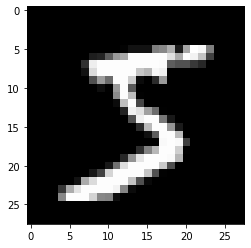

In [3]:
#TODO 1: Split the data intox1,x2,x3,x4,x5,x6,x7,x8,x9,10
(xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.mnist.load_data()
#? Checking the shape of the data, small preview
plt.imshow(xTrain[0], cmap='gray')


In [20]:
#TODO Posortować wszystkie zbiory wg. klasyfikacji ege. 1,2,3,4,.... (yTest, xTrain)
#TODO dodać macierze ze sobą (np. 1,7)
#TODO Odpalić compile na małych setach
#TODO Pomieszać klasy

def makeClassSet(xTrainSet, yTrainSet, xTestClass, yTestClass, firstclassNumber:int,secondclassNumber:int):
    """_summary_

    Args:
        xTrainSet (_type_): _description_
        yTrainSet (_type_): _description_
        xTestClass (_type_): _description_
        yTestClass (_type_): _description_
        firstclassNumber (int): _description_
        secondclassNumber (int): _description_

    Returns:
        _type_: _description_
    """
    # xtrain
    firstTrainSet = xTrainSet[yTrainSet == firstclassNumber]
    secondTrainSet = xTrainSet[yTrainSet == secondclassNumber]
    xTrainArray = np.append(firstTrainSet, secondTrainSet, axis=0)
    
    # yTrain
    trainFirstClassY = [firstclassNumber] * firstTrainSet.shape[0]
    trainSecondClassY = [secondclassNumber] * firstTrainSet.shape[0]
    trainYArray = np.append(trainFirstClassY, trainSecondClassY, axis=0)
    
    # xTest
    firstTestSet = xTestClass[yTestClass == firstclassNumber]
    secondTestSet = xTestClass[yTestClass == secondclassNumber]
    xTestArray = np.append(firstTestSet, secondTestSet, axis=0)
    
    # yTest
    testFirstClassY = [firstclassNumber] * firstTestSet.shape[0]
    testSecondClassY = [secondclassNumber] * firstTestSet.shape[0]
    testYArray = np.append(testFirstClassY, testSecondClassY, axis=0)
    
    
    xTrainArray = xTrainArray.reshape((len(xTrainArray), np.prod(xTrainArray.shape[1:])))
    xTestArray = xTestArray.reshape((len(xTestArray), np.prod(xTestArray.shape[1:])))
    
    xTrainArray =  xTrainArray.astype('float32') / (255)
    xTestArray = xTestArray.astype('float32') / (255)

    
    return (xTrainArray, trainYArray), (xTestArray, testYArray)

def prepareAutoencoderModel():
    encoding_dimension = 32
    # This is our input image
    input_img = keras.Input(shape=(784,))
    # "encoded" is the encoded representation of the input
    encoded = keras.layers.Dense(encoding_dimension, activation='relu')(input_img)
    # "decoded" is the lossy reconstruction of the input
    decoded =keras.layers.Dense(784, activation='sigmoid')(encoded)

    # This model maps an input to its reconstruction
    autoencoder = keras.Model(input_img, decoded, name='Autoencoder')
    # This model maps an input to its encoded representation
    encoder = keras.Model(input_img, encoded, name='Encoder')
    # This is our encoded (32-dimensional) input
    encoded_input = keras.Input(shape=(encoding_dimension,))
    # Retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # Create the decoder model
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input), name='Decoder')

    tf.keras.utils.plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

    opt = keras.optimizers.Adam(lr=0.001, decay=1e-6) #* Adam optimizer

    autoencoder.compile(optimizer=opt, loss='mse')
    autoencoder.summary()
    return encoder, decoder, autoencoder

def fitTheModel(xTrain, yTrain, xTest, yTest):
    """Returns images - encoded and decoded"""


    es = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)
    encoder, decoder, autoencoder = prepareAutoencoderModel()
    autoencoder.fit(xTrain, xTrain, epochs=10, batch_size=32,validation_split= 0.1, callbacks=[es, TensorBoard(log_dir='/tmp/autoencoder')], shuffle=True)
    encoded_imgs = encoder.predict(xTest)
    decoded_imgs = decoder.predict(encoded_imgs)
    autoencoded_imgs = autoencoder.predict(xTest)
    
    return encoded_imgs, decoded_imgs, autoencoded_imgs

def plotTheResults(xTest,encoded_imgs,autoencoded_imgs,  n = 10):
    # How many digits we will display
    plt.figure(figsize=(30,8))
    listOfPreviesIndexes = []
    for i in range(n):
        randomIndex =  np.random.randint(0,(xTest.shape[0] ))
        while randomIndex in listOfPreviesIndexes:
            randomIndex =  np.random.randint(0,(xTest.shape[0] ))
        listOfPreviesIndexes.append(randomIndex)
        
        # Display original
        
        ax = plt.subplot(3, n, i + 1)
        plt.imshow(xTest[randomIndex].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Test Image")

        # Display reconstruction
        ax = plt.subplot(3, n, i + 1 + n)
        # plt.imshow(encoded_imgs[i].reshape(28, 28))
        plt.imshow(encoded_imgs[randomIndex].reshape(-1,8), cmap='gray')
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_title("Encoded Image")
        
        # Display autoencoder
        ax = plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(autoencoded_imgs[randomIndex].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        ax.set_title("Auto Encoded Image")
        
    plt.show()

## Encoder part

## Decoder part

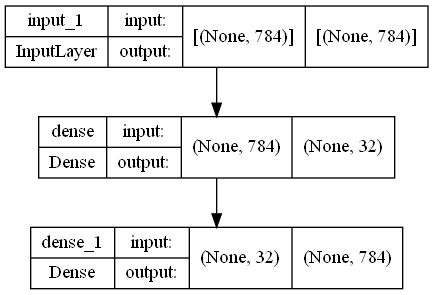

In [6]:
encoding_dimension = 32
# This is our input image
input_img = keras.Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = keras.layers.Dense(encoding_dimension, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded =keras.layers.Dense(784, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded, name='Autoencoder')
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded, name='Encoder')
# This is our encoded (32-dimensional) input
encoded_input = keras.Input(shape=(encoding_dimension,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input), name='Decoder')
# tf.keras.plot_model(encoder, 'encoder_no_compress.png', show_shapes=True)
tf.keras.utils.plot_model(autoencoder, to_file='autoencoder.png', show_shapes=True)

### Tensorflow/Keras configuration

In [7]:

#* Gradient clipping involves forcing the gradient values (element-wise) to a specific minimum
#* or maximum value if the gradient exceeded an expected range.
# opt = keras.optimizers.Adam(lr=0.001, decay=0.0001, clipvalue=0.5, clipnorm=1, amsgrad=True, ) #* Adam optimizer
opt = keras.optimizers.Adam(lr=0.001, decay=1e-6) #* Adam optimizer
# opt = keras.optimizers.Adam(lr=0.001, decay=0.0001) #* Adam optimizer
es = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

c:\Users\szink\OneDrive\Pulpit\Studia\MachineLearning\virtualEnv_ML_DIR\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


#### Encoded image

#### How it is supposed to look

#### Confusiuon Matrixies

In [11]:
encoder, decoder, autoencoder = prepareAutoencoderModel()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_2 (Dense)             (None, 32)                25120     
                                                                 
 dense_3 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________


In [10]:
(xTrainSet27, yTrainSet27), (xTestSet27,yTestSet27) = makeClassSet(xTrainSet=xTrain, yTrainSet=yTrain, xTestClass=xTest, yTestClass=yTest, firstclassNumber=2, secondclassNumber=7)


In [18]:
encoded_imgs, decoded_imgs, autoencoded_imgs = fitTheModel(xTrainSet27, yTrainSet27, xTestSet27, yTestSet27)

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 784)]             0         
                                                                 
 dense_6 (Dense)             (None, 32)                25120     
                                                                 
 dense_7 (Dense)             (None, 784)               25872     
                                                                 
Total params: 50,992
Trainable params: 50,992
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10


c:\Users\szink\OneDrive\Pulpit\Studia\MachineLearning\virtualEnv_ML_DIR\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


344/344 [==============================] - 1s 2ms/step - loss: 0.0593 - val_loss: 0.0280
Epoch 2/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0306 - val_loss: 0.0204
Epoch 3/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0236 - val_loss: 0.0164
Epoch 4/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0194 - val_loss: 0.0139
Epoch 5/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0167 - val_loss: 0.0120
Epoch 6/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0147 - val_loss: 0.0108
Epoch 7/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0132 - val_loss: 0.0097
Epoch 8/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0120 - val_loss: 0.0089
Epoch 9/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0111 - val_loss: 0.0082
Epoch 10/10
344/344 [==============================] - 1s 2ms/step - loss: 0.0104 - val_loss: 0.0078


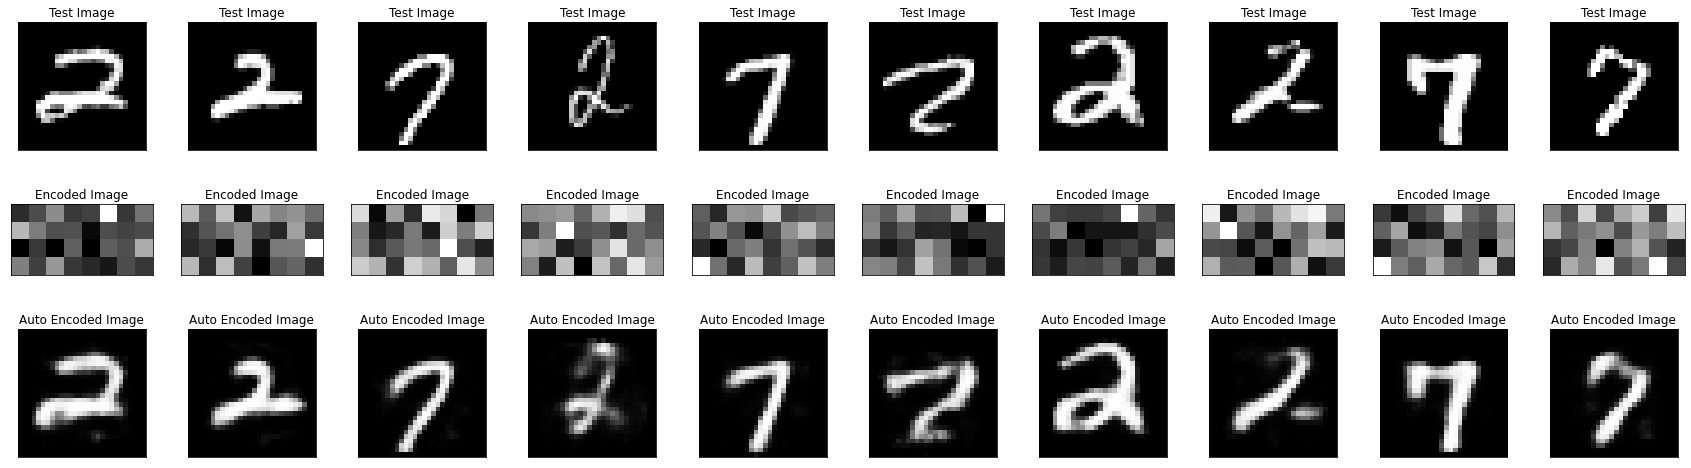

In [23]:
plotTheResults(xTest=xTestSet27,  encoded_imgs=encoded_imgs, autoencoded_imgs=autoencoded_imgs)